In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import sklearn
from matplotlib import pyplot as plt

from dataclasses import dataclass
from pathlib import Path

from datasail.sail import datasail
import json
import joblib

import rdkit


from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Утилитарные классы

In [161]:
@dataclass
class Config:
    DEVICE: str = 'cuda:0'
    DATA_PATH: Path = Path('data/')
    N_THREADS: int = 3

config = Config()

# EDA 

In [149]:
data = pd.read_csv(config.DATA_PATH / 'boiling_points.csv')
data.head()

,smiles,value,source,name,units,params
0,CC1(C)c2ccccc2-c2ccc(N(c3ccc4c(c3)C3(c5ccccc5-...,500.000,ECHA,Boiling point,°C,NaN
1,Cc1ccc(C=CCl)cc1,223.000,NaN,Boiling point,°C,NaN
2,COc1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,929.624,NaN,Boiling point,°C,NaN
3,CC=Cc1ccc(OCC)cc1,242.000,NaN,Boiling point,°C,NaN
4,CCCCCCCCCCc1cccc2ccccc12,379.000,Handbook of chemistry and physics 2016,Boiling point,°C,NaN


In [150]:
data.describe()

,value,params
count,11699.000000,0.0
mean,225.675892,NaN
std,118.290078,NaN
min,-191.500000,NaN
25%,151.000000,NaN
50%,218.000000,NaN
75%,282.975000,NaN
max,2262.000000,NaN


In [166]:
data

,index,smiles,value,source,name,units,params
0,0,CC1(C)c2ccccc2-c2ccc(N(c3ccc4c(c3)C3(c5ccccc5-...,500.000,ECHA,Boiling point,°C,NaN
1,1,Cc1ccc(C=CCl)cc1,223.000,NaN,Boiling point,°C,NaN
2,2,COc1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,929.624,NaN,Boiling point,°C,NaN
3,3,CC=Cc1ccc(OCC)cc1,242.000,NaN,Boiling point,°C,NaN
4,4,CCCCCCCCCCc1cccc2ccccc12,379.000,Handbook of chemistry and physics 2016,Boiling point,°C,NaN
...,...,...,...,...,...,...,...
11694,11694,Cc1cc(C)[nH]n1,220.000,ECHA,Boiling point,°C,NaN
11695,11695,Cc1ccc(N)nc1,213.300,ECHA,Boiling point,°C,NaN
11696,11696,Cc1ccc(O)c(O)c1,258.000,Handbook of chemistry and physics 2016,Boiling point,°C,NaN
11697,11697,Cc1ccsc1,115.400,Handbook of chemistry and physics 2016,Boiling point,°C,NaN


In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11699 entries, 0 to 11698
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  11699 non-null  object 
 1   value   11699 non-null  float64
 2   source  7854 non-null   object 
 3   name    11699 non-null  object 
 4   units   11699 non-null  object 
 5   params  0 non-null      float64
dtypes: float64(2), object(4)
memory usage: 548.5+ KB


In [152]:
for col in data.columns:
    print(f'Пропуски в колонке {col}: {data[col].isna().sum()}')

Пропуски в колонке smiles: 0
Пропуски в колонке value: 0
Пропуски в колонке source: 3845
Пропуски в колонке name: 0
Пропуски в колонке units: 0
Пропуски в колонке params: 11699


In [153]:
data['name'].unique()

array(['Boiling point'], dtype=object)

In [154]:
data['units'].unique()

array(['°C'], dtype=object)

In [155]:
data['smiles'].duplicated().sum()

0

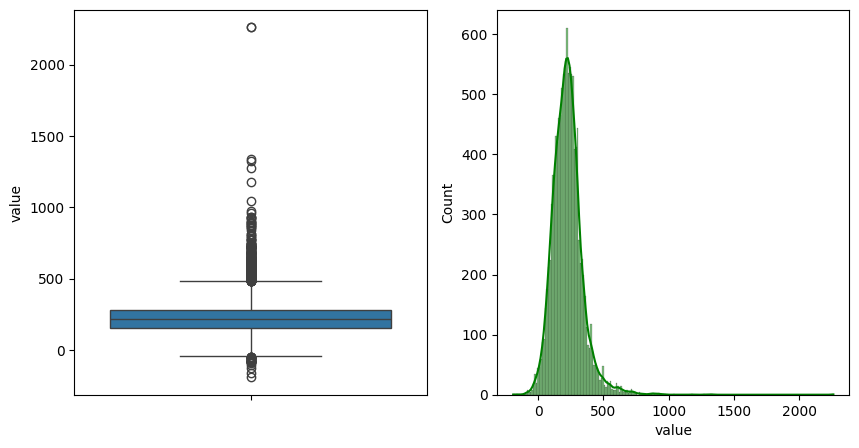

In [156]:
def plot_target(target: pd.Series):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.add_subplot(sns.boxplot(target, ax=axes[0]))
    fig.add_subplot(sns.histplot(target, ax=axes[1], kde=True, color='green'))


plot_target(data['value'])

На графиках можем увидеть большое количество выбросов за межквартильным размахом. Распределение очевидно стремится к форме негативного биномиального распределения за счёт высокого смещения. Дополнительно применим тест Колмогорова-Смирнова (Шапиро-Уилка стоит использовать на меньших выборках) и skewness/kurtosis на нормальность распределения.

In [157]:
def ks_test(target: pd.Series):
    mu, sigma = np.mean(target), np.std(data['value'], ddof=1)
    stat, p_value = scipy.stats.kstest(target, 'norm', args=(mu, sigma))

    skew = scipy.stats.skew(target)
    kurtosis = scipy.stats.kurtosis(target)

    print(f"КС-тест = {stat}")
    print(f"p-value = {p_value}")
    print(f"Сдвиг: {skew}")
    print(f"Эксцесс: {kurtosis}")

ks_test(data['value'])

КС-тест = 0.07513711891339248
p-value = 6.915447579828496e-58
Сдвиг: 2.077678742125133
Эксцесс: 20.00814397753698


Ожидаемо тест указывает на существенное отклонение от нормального распределения

### Удаление выбросов с помощью правила 3 сигм (z-score)

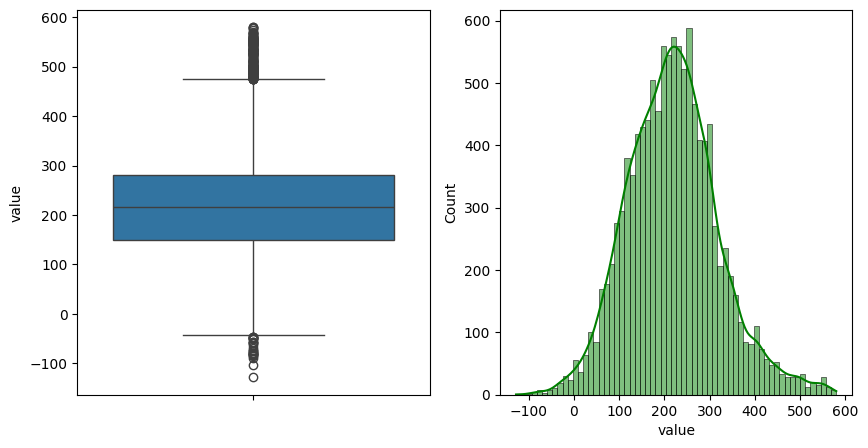

In [158]:
threshold: float = 3.0 
z_scores = scipy.stats.zscore(data['value'])
outlier_mask = np.abs(z_scores) > threshold
data_clean = data[~outlier_mask]

plot_target(data_clean['value'])

In [159]:
ks_test(data_clean['value'])

КС-тест = 0.0680691830632002
p-value = 5.793634112706241e-47
Сдвиг: 0.3563562276942144
Эксцесс: 0.517271389808335


Видим значительное улучшение как визуальной формы распределения, так и статистических тестов. КС-тест всё ещё показывает значительное отклонение от нормальности, возможно, статистически будет верно использовать в качестве "отсеивания" межквартильный размах, но стоит сохранить большее количество данных для обучения моделей

In [160]:
print(f'Итоговая разница размерностей: {data.shape[0] - data_clean.shape[0]}')

Итоговая разница размерностей: 152


# Разделение данных

В качестве средства для разделения по train-test выборкам будем использовать [DataSail](https://github.com/kalininalab/DataSAIL) в соотношении 80/20

In [173]:
df_index = data_clean.reset_index()
e_splits, _, _ = datasail(
    techniques=["C1e"],
    splits=[8, 2],
    names=["train","test"],
    runs=5,
    solver="SCIP",
    e_type="M",
    threads=config.N_THREADS,
    e_data=dict(df_index[["index", "smiles"]].values.tolist())
)

: 